In [1]:
import requests
import lxml.html as html
import datetime
import os
import os.path

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


#NLP
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import FreqDist

In [2]:
#La nación
home_url = 'https://www.lanacion.com.ar/'
xpath_principal_link = '//h1[@class = "com-title"]/a/@href'
xpath_links = '//h2[@class="com-title"]/a/@href'

#Nota
xpath_title = '//h1[@class = "titulo"]/text()'
xpath_author = '//section[@class = "autor"]/a/text()'
xpath_epigrafe = '//figcaption/epigrafe/text()'
xpath_body = '//article[@id = "nota"]/section[@id = "cuerpo"]/p/text()'



In [3]:
#Recibe una lista de strings y devuelve un string
def clear_body(body):
    news = []
    for i in body:
        news.append(i)

    flatten = [n for l in news for n in l]
    
    text = ""
    for item in flatten:
        text += item
        
    return text

In [4]:
def parse_notice(link, today):
    try:
        response = requests.get(home_url+link)
        if response.status_code == 200:
            new = response.content.decode('utf-8')
            parsed = html.fromstring(new)
            
            try:
                title = parsed.xpath(xpath_title)
                author = parsed.xpath(xpath_author)
                epigrafe = parsed.xpath(xpath_epigrafe)
                body = parsed.xpath(xpath_body)
                
            except IndexError:
                print("as")
            
            title = str(title).replace('[','').replace(']','').replace('\'','')
            author = str(author).replace('[','').replace(']','').replace('\'','')
            epigrafe = str(epigrafe).replace('[','').replace(']','').replace('\'','')
            body= clear_body(body).replace('\n','').replace('\r','').replace('  ','')
            
            with open('out/'+today+'/News/'+title+'.txt', 'w', encoding='utf-8') as f:
                f.write(title)
                f.write('\n\n')
                f.write(author)
                f.write('\n\n')
                f.write(epigrafe)
                f.write('\n\n')
                f.write(body)
                f.write('\n\n')
    
        else:
            raise ValueError(f'Error: {response.status_code}')
    
    except ValueError as ve:
        print(ve)

In [5]:
def parse_home():
    try:
        response = requests.get(home_url)
        if response.status_code == 200:
            home = response.content.decode('utf-8')
            parsed =  html.fromstring(home) 
            link_principal = parsed.xpath(xpath_principal_link)
            links_to_notices = parsed.xpath(xpath_links) #Extrigo los links de las noticias
            today = datetime.date.today().strftime('%d-%m-%Y')
            
            #Creo la carpeta con las noticias del día
            if not os.path.isdir('out/'+today+'/News'):
                os.mkdir('out/'+today)
                os.mkdir('out/'+today+'/News')
                

            parse_notice(link_principal[0], today)
            
            for link in links_to_notices:
                parse_notice(link, today)
                
        else:
            raise ValueError(f'Error: {response.status_code}')
            
    except ValueError as ve:
        prtin(ve)


In [6]:
parse_home()

In [7]:
def word_cloud(date):
    
    #1. Tokenizo por palabras con el pattern de a continuacion (pattern: forma en la que nltk identifica palabras en el corpus)
    pattern = r'''(?x)                  # Flag para iniciar el modo verbose
                  (?:[A-Z]\.)+            # Hace match con abreviaciones como U.S.A.
                  | \w+(?:-\w+)*         # Hace match con palabras que pueden tener un guión interno
                  | \$?\d+(?:\.\d+)?%?  # Hace match con dinero o porcentajes como $15.5 o 100%
                  | \.\.\.              # Hace match con puntos suspensivos
                  | [][.,;"'?():-_`]    # Hace match con signos de puntuación
    '''
    docs = os.listdir('out/'+date+'/News')
    
    for d in docs:
        data = open('out/'+date+'/News/'+ d).read()
        title = data.split('\n\n')[0]
    

        word_token = nltk.regexp_tokenize(data, pattern= pattern)
        

        #2. Llamo las stopwords de nltk
        stop_word_es = stopwords.words('spanish')
        word_token = [palabra for palabra in word_token if len(palabra)>2 and palabra not in stop_word_es]

        dist = FreqDist(word_token)
        importantes = pd.DataFrame(dist.most_common(40), columns=['word','freq'])

        #3. Transformo el array en un diccionario para graficarlo
        count = 0
        for i in range(len(importantes)):
            if count == 0:
                important = {importantes.iloc[i]['word']: int(importantes.iloc[i]['freq'])}
            else:
                important1 = {importantes.iloc[i]['word']: int(importantes.iloc[i]['freq'])}
                important.update(important1)
            count = count + 1

        wc = WordCloud(width=430, height=250,background_color="white").generate_from_frequencies(important)
        
        if not os.path.isdir('out/'+date+'/WordCloud/'):
                os.mkdir('out/'+date+'/WordCloud/')
        
        plt.figure(figsize=(12,12))
        plt.title(label= title, fontsize=14)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.savefig('out/'+date+'/WordCloud/'+str(title)+'.jpg')


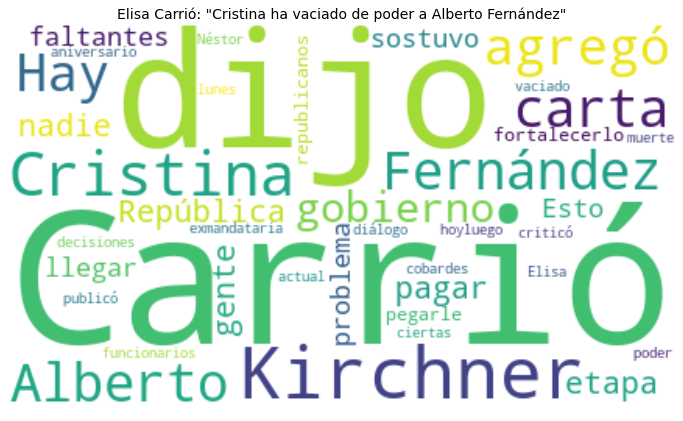

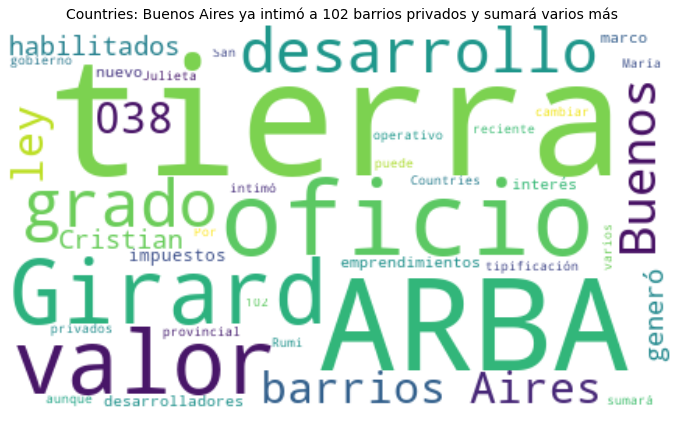

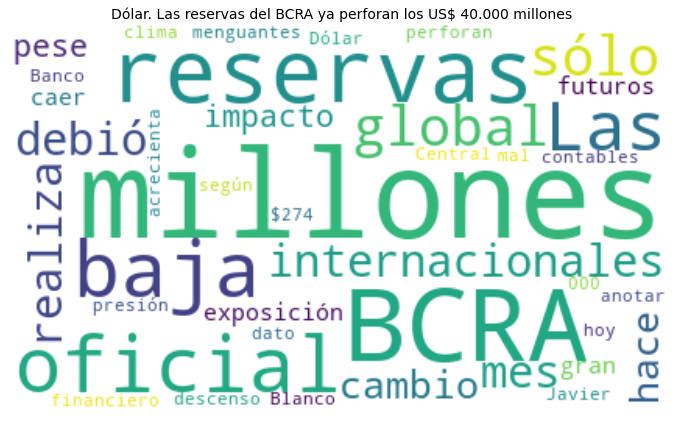

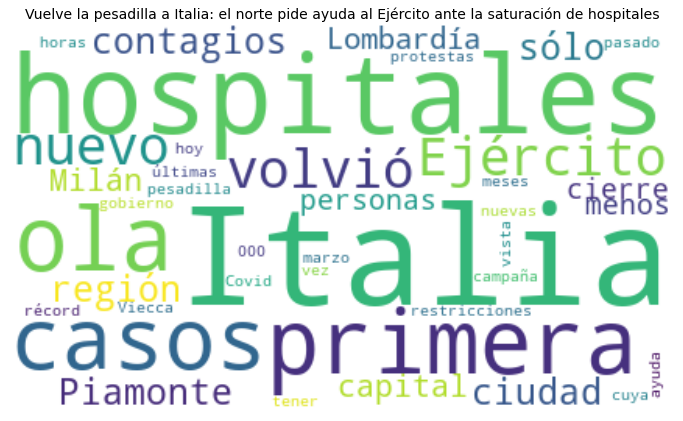

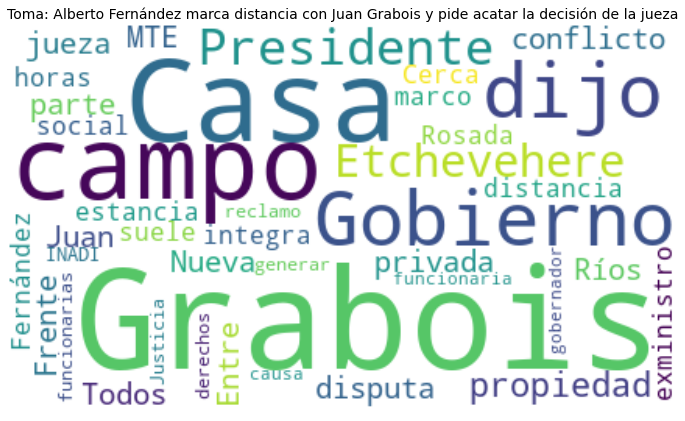

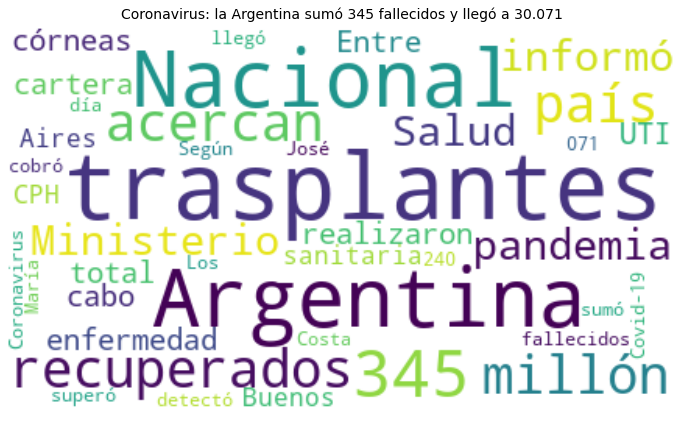

In [8]:
word_cloud('28-10-2020')